In [1]:
import matplotlib.pyplot as plt
import numpy as np
import mpmath as mp
from scipy.integrate import quad, dblquad, fixed_quad
import astropy.constants as C
import astropy.units as u
import sympy as sp
import math
from tqdm import tqdm

kpc = C.kpc.to_value()
pc = C.pc.to_value()
c = C.c.to_value()
MSun = C.M_sun.to_value()
G_num = C.G.to_value()
# yr = 3.154e7 # seconds
# day = 86400 # seconds
x = sp.Symbol('x')
L = sp.Symbol('L')
m = sp.Symbol('m')
t_E = sp.Symbol('t_E')
u_min = sp.Symbol('u_min')
u_T = sp.Symbol('u_T')
RSun=C.R_sun.to_value()

rho_0 = 0.0079 * (C.M_sun/u.pc**3).decompose() # local DM density
r_0 = 8.5 * u.kpc # distance from the Sun to the galaxy core
a = 5 * u.kpc # galaxy core radius
L = 50 * u.kpc # distance to the LMC stars
b = -32.8 # degrees - galactic coordinate
l = 281 # degrees - galactic coordinate

v_c = (220 * u.km/u.s).decompose()
# v_c = v_rot.value

In [155]:
def R_0(x, m): # input in x = distance/L and m = mass in solar masses
  
  arg = ((4*C.G * m*u.M_sun * L * x * (1 - x))/(C.c)**2).decompose()
  result = np.sqrt(abs(arg)).decompose()
  
  return result

def r(x): # input in x = distance/L 

  return (np.sqrt((r_0)**2 + (x*L)**2 - 2 * (r_0) * (x*L) * np.cos(math.radians(l))*np.cos(math.radians(b)))).decompose()

def rho_DM(x): # input in x = distance/L

  term1 = a**2 + r_0**2
  term2 = a**2 + r(x)**2

  return (rho_0 *(term1/term2)).decompose()



In [3]:
def integrand(x, t, m, u_T):
    Q = (4 * R_0(x,m)**2 * u_T)/((t*u.year)**2 * v_c**2).decompose()
    exp_factor = np.exp(-Q)
    factor = 32*L/((m*C.M_sun) * (t*u.year)**4 * v_c**2)

    integ = (factor * rho_DM(x) * exp_factor * R_0(x,m)**4 * u.year**2).decompose()

    return integ

@np.vectorize
def event_rate(t, m, u_T):

    integral = fixed_quad(integrand, 0, 1, args=(t, m, u_T), n=10000)[0]

    return integral

In [4]:
t_hat = np.logspace(-3, 4, 200)

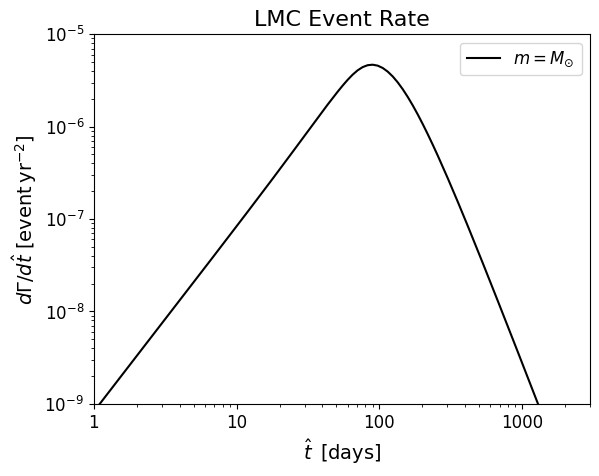

In [ ]:
import matplotlib.ticker as mticker



fig, ax = plt.subplots()
ax.set_title('LMC Event Rate', fontsize=16)
ax.loglog(t_hat*365, event_rate(t=t_hat, m=1, u_T=1), color='black', label=r'$m = M_{\odot}$')
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.set_xlabel(r'$\hat{t}\,$ [days]', fontsize=14)
ax.set_ylabel(r'$d\Gamma/d\hat{t}\,\, \mathrm{[event\, yr^{-2}}]$', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)


plt.ylim(1e-9, 1e-5)
plt.xlim(1,3000)

plt.show()

In [219]:
### Adapting this code to reproduce Niikura's event rate in t_hat ###

d_s = sp.Symbol('d_s')
d = sp.Symbol('d')
m_pbh = sp.Symbol('m_pbh')

rho_c_MW = 4.88e6 * MSun/kpc**3
rho_c_M31 = 4.96e6 * MSun/kpc**3
r_s_MW = 21.5 * kpc
r_s_M31 = 25 * kpc
r_sun = r_0.decompose().value
l_M31 = 121.2 # degree
b_M31 = -21.6 # degree
d_s = 770 * kpc
hour = 3600 # seconds

In [250]:
def R_E(d, m_pbh):
    arg = ((4*G_num * m_pbh * d * (1 - d/d_s))/(c)**2)
    result = np.sqrt(abs(arg))

    return result

### Distances

def r_MW(d):

    r_mw = np.sqrt((r_sun)**2 + d**2 - 2*r_sun*d*np.cos(np.radians(l_M31))*np.cos(np.radians(b_M31)))

    return r_mw 

def r_M31(d):

    r_m31 = (d_s - d)

    return r_m31 

### Dark matter densities

def density_DM_MW(d):

    term1 =  rho_c_MW
    term2 = (r_MW(d) / r_s_MW)
    term3 = (1 + r_MW(d) / r_s_MW)**2
    
    return (term1 /(term2 * term3))

def density_DM_M31(d):
    
    term4 = rho_c_M31               
    term5 = (r_M31(d) / r_s_M31)
    term6 = (1 + r_M31(d) / r_s_M31)**2
    
    return  (term4 / (term5 * term6))

def density_DM(d):
    
    return density_DM_MW(d) + density_DM_M31(d)

### NFW Masses

def M_NFW_MW(d):
  c = (r_MW(d)/r_s_MW)

  func1 = (4 * np.pi * rho_c_MW * (r_s_MW)**3)
  func2 =  (np.log(1 + c) - (c/(1 + c)))

  return func1 * func2

def M_NFW_M31(d):
   c = (r_M31(d)/r_s_M31)

   func1 = (4 * np.pi * rho_c_M31 * (r_s_M31)**3)
   func2 =  (np.log(1 + c) - (c/(1 + c)))
   return func1 * func2

### Peculiar velocities

def v_c_MW(d):
  v_c_MW = np.sqrt((G_num * M_NFW_MW(d))/r_MW(d))

  return v_c_MW

def v_c_M31(d):
    v_c_M31 = np.sqrt((G_num * M_NFW_M31(d))/r_M31(d))

    return v_c_M31

### Integrands

def integrand_MW(d, u_min, t, m_pbh):

    v_r = ((2 * R_E(d, m_pbh) * np.sqrt(1 - u_min**2))/(t))
    Q = v_r/v_c_MW(d)

    term1 = ((density_DM_MW(d))/(m_pbh * v_c_MW(d)**2 ))
    term2 = (v_r**4/np.sqrt(1 - u_min**2))
    term3 = np.exp(-Q**2)

    return  (2*term1*term2*term3)

def integrand_M31(d, u_min, t, m_pbh):

    v_r = ((2 * R_E(d, m_pbh) * np.sqrt(1 - u_min**2))/(t))
    Q = v_r/v_c_M31(d)

    term1 = ((density_DM_M31(d))/(m_pbh * v_c_M31(d)**2 ))
    term2 = (v_r**4/np.sqrt(1 - u_min**2))
    term3 = np.exp(-Q**2)

    return  ((2*term1*term2*term3))

### Event rate integrals

def event_rate_MW(t, m_pbh):

    integral = dblquad(integrand_MW, 0, 1, 0, d_s, args=(t, m_pbh,), epsabs=1.49e-03, epsrel = 5e-29)[0]

    return integral

def event_rate_M31(t, m_pbh):

    integral = dblquad(integrand_M31, 0, 1, 0, d_s, args=(t, m_pbh,), epsabs=1.49e-03, epsrel = 5e-29)[0]

    return integral

event_rate_M31(t=hour, m_pbh=1e-7*MSun)

@np.vectorize
def event_rate_HSC(t, m_pbh):

    return event_rate_M31(t, m_pbh) + event_rate_MW(t, m_pbh)

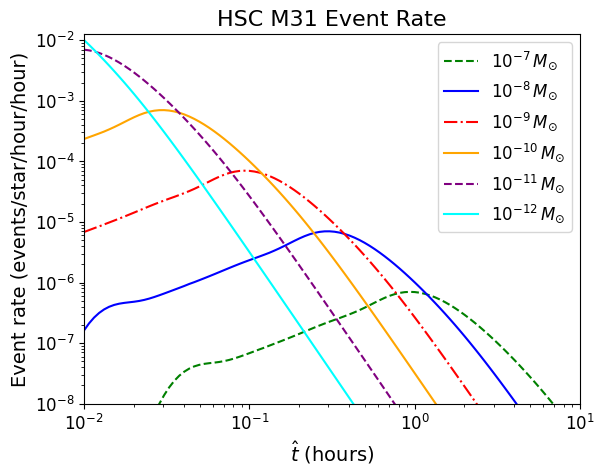

In [251]:
t_obs = np.geomspace(0.01, 10, 100)*hour

# plt.figure(figsize=(8,6))

plt.title('HSC M31 Event Rate', fontsize=16)

plt.loglog(t_obs/hour, hour**2 * event_rate_HSC(t=t_obs, m_pbh=1e-7*MSun), '--', color = 'green', label = r'$10^{-7}\, M_{\odot}$')
plt.loglog(t_obs/hour, hour**2 * event_rate_HSC(t=t_obs, m_pbh=1e-8*MSun), color = 'blue', label = r'$10^{-8}\, M_{\odot}$')
plt.loglog(t_obs/hour, hour**2 * event_rate_HSC(t=t_obs, m_pbh=1e-9*MSun), '-.', color = 'red', label = r'$10^{-9}\, M_{\odot}$')
plt.loglog(t_obs/hour, hour**2 * event_rate_HSC(t=t_obs, m_pbh=1e-10*MSun), color = 'orange', label = r'$10^{-10}\, M_{\odot}$')
plt.loglog(t_obs/hour, hour**2 * event_rate_HSC(t=t_obs, m_pbh=1e-11*MSun), '--', color = 'purple', label = r'$10^{-11}\, M_{\odot}$')
plt.loglog(t_obs/hour, hour**2 * event_rate_HSC(t=t_obs, m_pbh=1e-12*MSun), color = 'cyan', label = r'$10^{-12}\, M_{\odot}$')

plt.xlabel(r'$\hat{t}$ (hours)', fontsize=14)
plt.ylabel('Event rate (events/star/hour/hour)', fontsize=14)
ax = plt.gca()
ax.set_ylim([10**(-8), 10**(-1.9)])
ax.set_xlim([10**(-2), 10**(1)])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()